In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections
import sklearn
from sklearn import linear_model
import psutil
import pickle
import functools
from matplotlib import cm
from IPython.display import display
from sklearn import utils

In [1]:
#GRAPH_DIR = 'data/graphs/ng-20-single'
GRAPH_DIR = 'data/graphs/ng20-co-occurrence'
ORIGINAL_DOCUMENTS_DIR = 'extract-concept-graphs/code/data/ng20__single/train'

In [17]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [9]:
def get_graphs(directory, ext = 'gml', undirected = False, verbose = False, limit_elements = -1):
    graphs = {}
    empty_graphs = []
    files = sorted(glob(directory + '/*' + ext))
    graph_ids = []
    file_list = list(enumerate(files))
    if limit_elements != -1:
        file_list = sklearn.utils.shuffle(file_list)[:limit_elements]
    for idx, graph_file in helper.log_progress(file_list, every = 100):
        topic_and_id = graph_file.split('/')[-1].replace('.gml', '')
        
        topic = topic_and_id.split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
                graph_ids.append(topic_and_id)
            else:
                empty_graphs.append(topic_and_id)
                if verbose: print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            if verbose: print('Exception ({}): {}'.format(graph_file, e))
    if verbose: print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs, empty_graphs, graph_ids

graphs_per_topic, empty_graphs, graph_ids = get_graphs(GRAPH_DIR, undirected = False, verbose = False, limit_elements = 300)

## Retrieve original documents

In [6]:
def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
    topics = collections.defaultdict(lambda: [])
    for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
        topic_and_id = file.split('/')[-2]
        topic = topic_and_id.split('_')[0]
        if topic_and_id not in whitelist:
            if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
            continue
        with open(file) as f:
            topics[topic].append(f.read())
    return topics
docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)

Widget Javascript not detected.  It may not be installed or enabled properly.


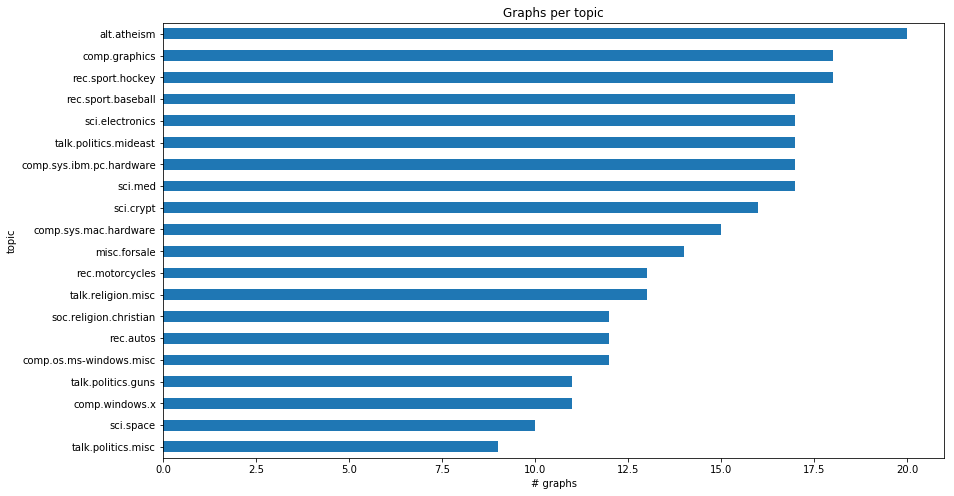

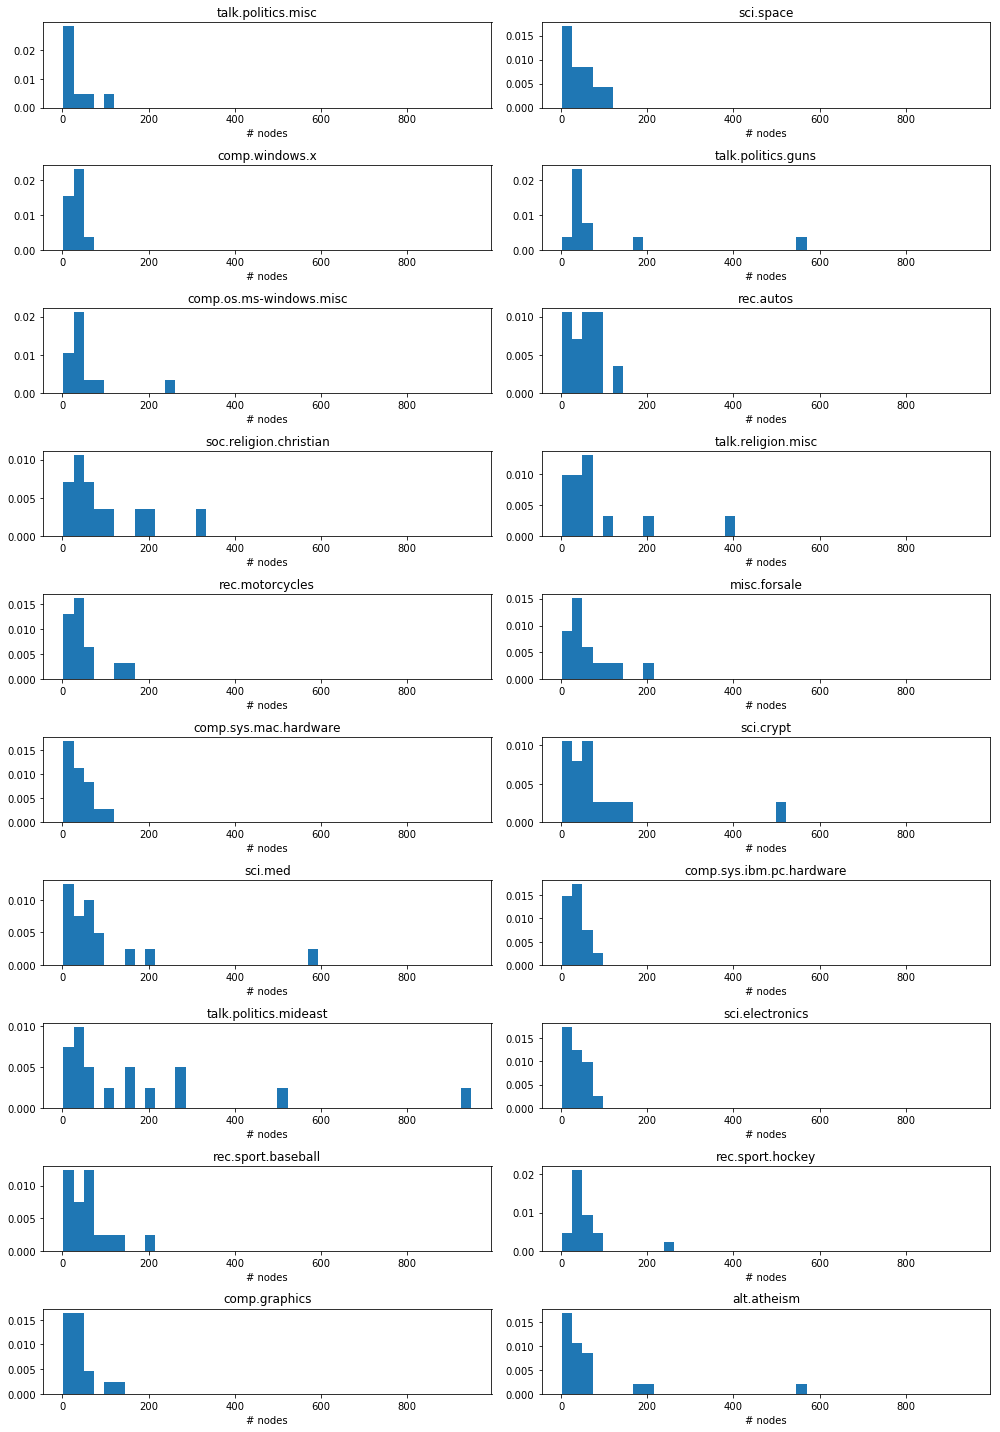

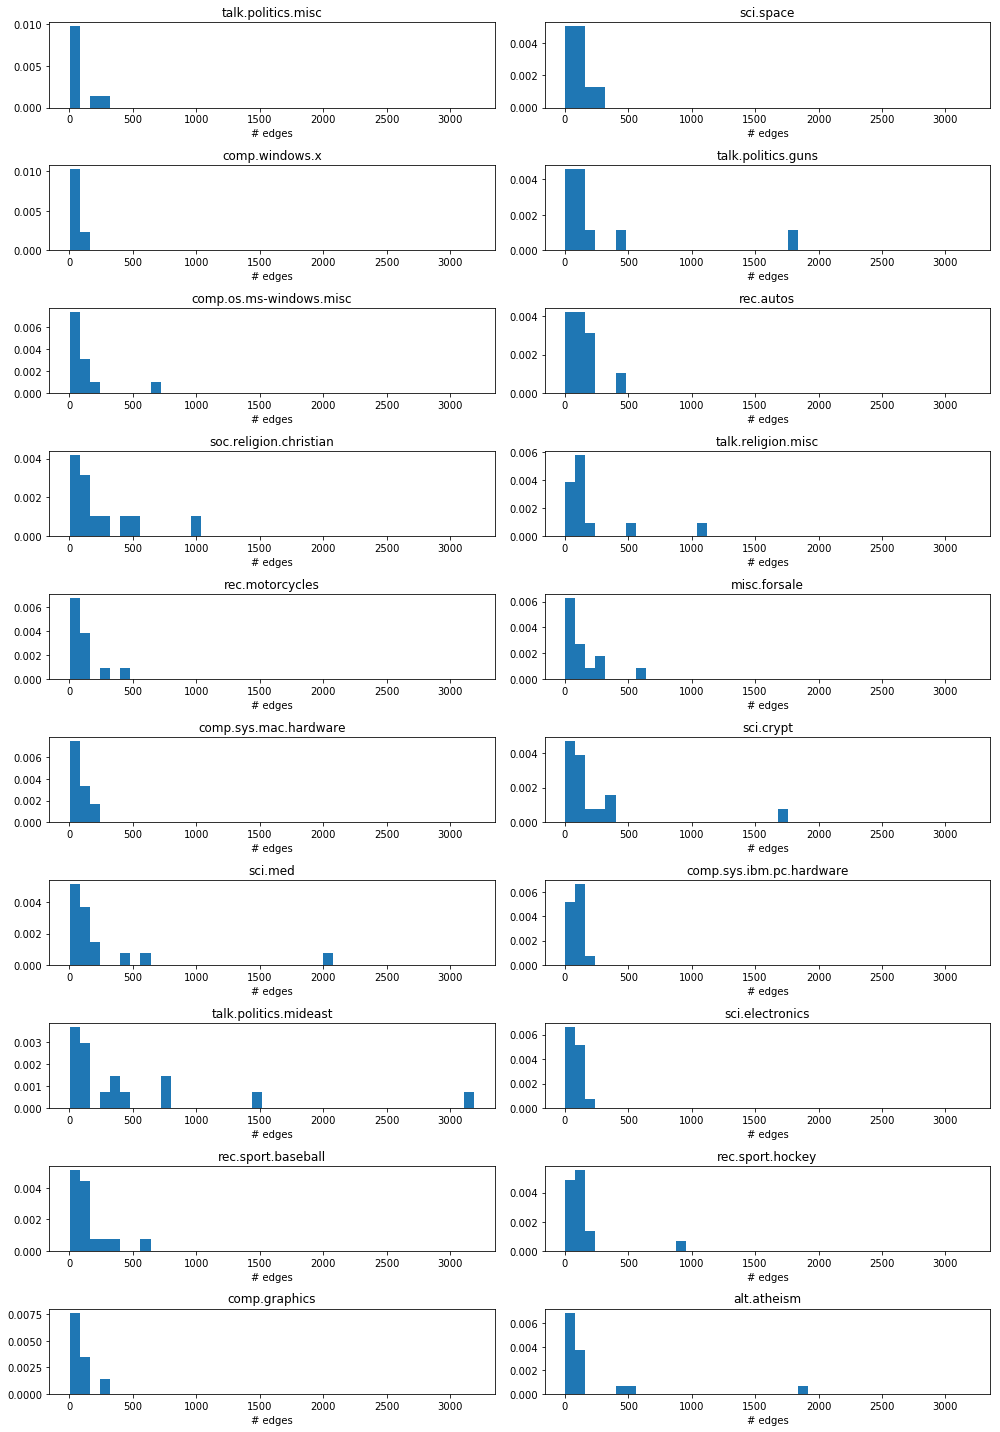

In [10]:
df_graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = df_graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(df_graphs_per_topic, 'num_nodes')
edges_range = get_range_of(df_graphs_per_topic, 'num_edges')
plt.show()
ncols, nrows = (2, 10)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(df_graphs_per_topic.iterrows()):
    row = int(idx / ncols)
    col = idx % ncols
    ax = axes[row][col]
    ax_ = axes_[row][col]
    
    # 
    ax.set_title("{}".format(topic))
    ax.set_xlabel('# nodes')
    ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)
    
    #
    ax_.set_title("{}".format(topic))
    ax_.set_xlabel('# edges')
    ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
fig.tight_layout()
fig_.tight_layout()
plt.show()

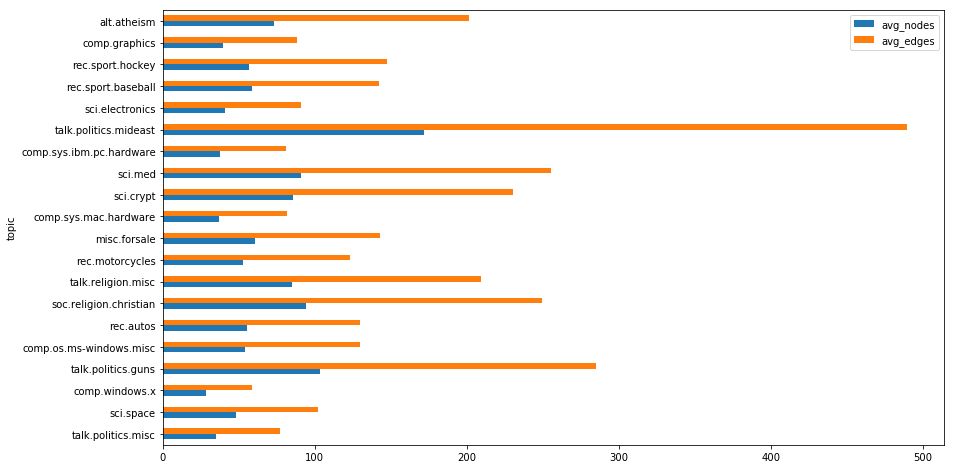

In [11]:
df_graphs_per_topic['avg_nodes'] = df_graphs_per_topic.num_nodes.apply(lambda x: np.mean(x))
df_graphs_per_topic['avg_edges'] = df_graphs_per_topic.num_edges.apply(lambda x: np.mean(x))
df_graphs_per_topic.plot(kind = 'barh', y = ['avg_nodes', 'avg_edges'], figsize = (14, 8))
plt.show()

## Filter categories

In [15]:
REMOVE_CATEGORIES = ['misc.forsale', 'comp.graphics']
REMOVE_CATEGORIES = []
graphs = graphs_per_topic.copy()
#docs = docs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]
        #del docs[cat]

In [18]:
all_graphs = flatten(graphs.values())
#all_docs = flatten(docs.values())

In [19]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())

In [20]:
print('#docs:\t\t{}\n#graphs:\t{}'.format(len(all_docs), len(all_graphs)))
print('Unique tokens found: {}'.format(len(all_nodes)))
assert len(all_docs) == len(all_graphs)

NameError: name 'all_docs' is not defined

## Create train/test split

In [21]:
def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test

train, test = get_train_test_split(graphs)

In [22]:
print('#graphs\n\ttrain:\t{}\n\ttest:\t{}'.format(len(train), len(test)))

#graphs
	train:	222
	test:	67


In [25]:
H = 2

## Calculate phi and gram-matrix of WL kernel for training instances

In [31]:
adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)
    
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=3355705344, percent=60.9, used=8266047488, free=44752896, active=3416788992, inactive=3310952448, wired=1538306048)
Number of original labels 8218
K original is computed
Iteration 0: phi is computed
	Graph          0/222
Number of compressed labels 14722
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/222
Number of compressed labels 14722
Itaration 1: phi computed
Calculating WL_train: end svmem(total=8589934592, available=3332931584, percent=61.2, used=8279244800, free=27893760, active=3431198720, inactive=3305037824, wired=1543008256)


## Train classifier with the phi s of the training instances

In [32]:
clf = sklearn.linear_model.Perceptron(n_iter = 500, verbose = False, n_jobs = -1)
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=500, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=False, warm_start=False)

## Get predictions for test instances

### Calculate test phi s

In [33]:
%%time
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]

CPU times: user 4.53 s, sys: 36.3 ms, total: 4.56 s
Wall time: 4.58 s


In [34]:
nodes_nums = sum([nx.number_of_nodes(graph) for topic, graph in train])
nodes_nums

14722

### Predict test instances

In [35]:
%%time
def calculate_batches(l, fn, num_batches = 10, print_every = 5):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % print_every == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 67, #batches: 10, #elements per Batch: 7
	Iteration:    0/10
	Iteration:    5/10
CPU times: user 18.1 ms, sys: 2.94 ms, total: 21 ms
Wall time: 21.1 ms


### Metrics

In [36]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

#### About sparsity of test phi

In [37]:
df_phi_test_non_zero_elements = pd.DataFrame(list(zip(Y_real, Y_pred, [np.count_nonzero(x) for x in phi_test])), columns = ['real_topic', 'pred_topic', 'num_phi_non_zero'])

In [38]:
display(df_phi_test_non_zero_elements.groupby(by = 'real_topic').describe())
display(df_phi_test_non_zero_elements.groupby(by = 'pred_topic').describe())

num_phi_non_zero                                \
                                    count        mean         std   min   
real_topic                                                                
alt.atheism                           4.0   33.500000   18.947295  10.0   
comp.graphics                         4.0   25.000000    6.782330  18.0   
comp.os.ms-windows.misc               3.0  108.666667  115.660423  22.0   
comp.sys.ibm.pc.hardware              4.0   36.000000   15.556349  18.0   
comp.sys.mac.hardware                 3.0   35.333333   22.590558  14.0   
comp.windows.x                        3.0   31.333333    4.509250  27.0   
misc.forsale                          3.0   16.000000   13.527749   2.0   
rec.autos                             3.0   30.666667   17.009801  18.0   
rec.motorcycles                       3.0   47.000000   30.805844  12.0   
rec.sport.baseball                    4.0   46.250000   21.140404  20.0   
rec.sport.hockey                      4.0   88.250000  105.351396  29.0   
sci.crypt                             4.0   78.000000   49.959984  26.0   
sci.electronics                       4.0   35.500000   19.052559  20.0   
sci.med                               4.0  174.500000  272.716581  12.0   
sci.space                             2.0   54.000000   56.568542  14.0   
soc.religion.christian                3.0   45.333333   35.501174   6.0   
talk.politics.guns                    3.0  262.333333  272.635899  36.0   
talk.politics.mideast                 4.0   96.000000  116.644760  14.0   
talk.politics.misc                    2.0   45.000000   28.284271  25.0   
talk.religion.misc                    3.0   47.333333   33.291641   9.0   

                                                        
                             25%    50%     75%    max  
real_topic                                              
alt.atheism                25.75   34.0   41.75   56.0  
comp.graphics              20.25   24.5   29.25   33.0  
comp.os.ms-windows.misc    43.00   64.0  152.00  240.0  
comp.sys.ibm.pc.hardware   26.25   36.5   46.25   53.0  
comp.sys.mac.hardware      23.50   33.0   46.00   59.0  
comp.windows.x             29.00   31.0   33.50   36.0  
misc.forsale                9.50   17.0   23.00   29.0  
rec.autos                  21.00   24.0   37.00   50.0  
rec.motorcycles            35.50   59.0   64.50   70.0  
rec.sport.baseball         35.00   48.0   59.25   69.0  
rec.sport.hockey           32.75   39.0   94.50  246.0  
sci.crypt                  44.00   74.0  108.00  138.0  
sci.electronics            20.00   31.5   47.00   59.0  
sci.med                    28.50   52.0  198.00  582.0  
sci.space                  34.00   54.0   74.00   94.0  
soc.religion.christian     30.50   55.0   65.00   75.0  
talk.politics.guns        111.00  186.0  375.50  565.0  
talk.politics.mideast      38.75   50.5  107.75  269.0  
talk.politics.misc         35.00   45.0   55.00   65.0  
talk.religion.misc         36.50   64.0   66.50   69.0

num_phi_non_zero                                                \
                       count       mean         std  min   25%   50%   75%   
pred_topic                                                                   
alt.atheism             67.0  67.492537  103.969164  2.0  21.5  36.0  61.5   

                    
               max  
pred_topic          
alt.atheism  582.0

In [39]:
max_ = 0
vals_over_1 = 0
for i in phi_test:
    vals = i[i > 1]
    if not len(vals): continue
    vals_over_1 += 1
    m = max(vals)
    if m > max_:
        max_ = m
        print(max_)
print(vals_over_1)

0


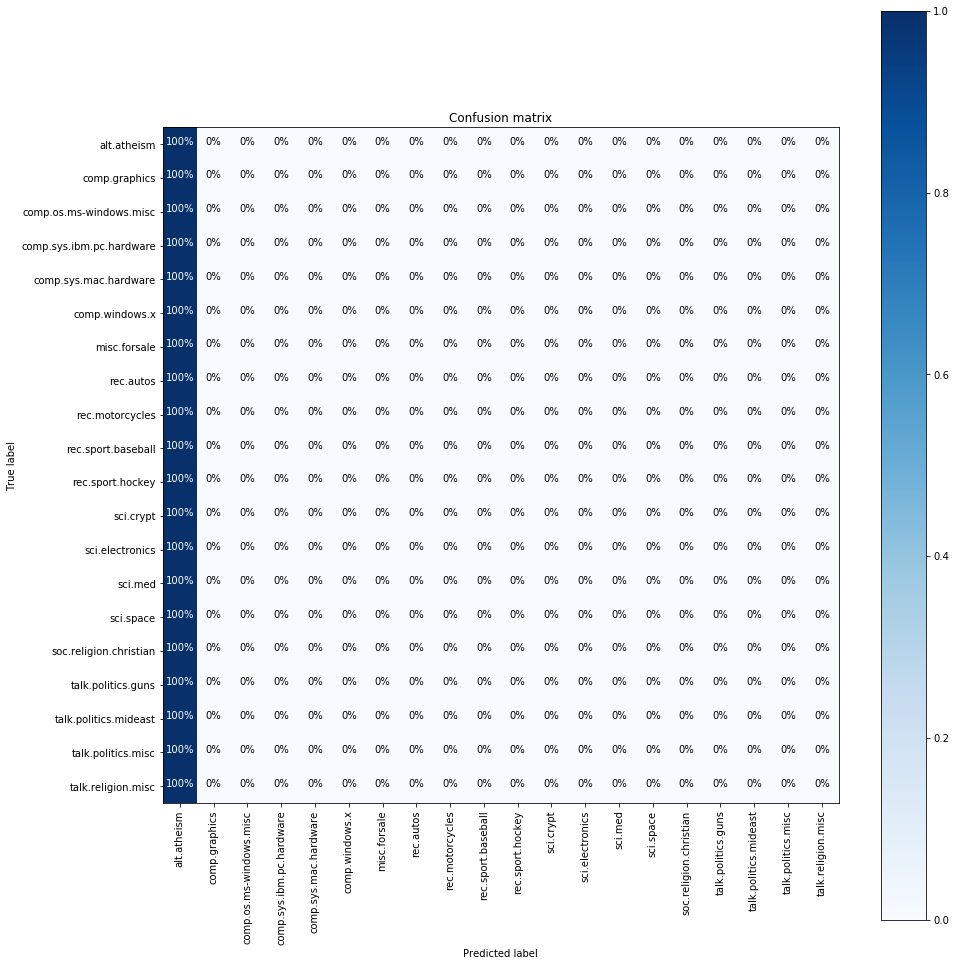

In [40]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)
fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [41]:
with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)